# Day 1: Stationarity and Unit Root Tests
## Week 3: Time Series Analysis for Finance

---

### 🎯 Learning Objectives
- Understand stationarity and why it matters
- Apply ADF, KPSS, and Phillips-Perron tests
- Transform non-stationary data
- Identify I(0) vs I(1) processes

---

### 📈 Why Stationarity Matters in Trading

**What is Stationarity?**

A stationary time series has constant statistical properties (mean, variance) over time. It "looks the same" regardless of when you observe it.

### The Key Insight

- **Stock PRICES**: Non-stationary (they trend, don't revert to mean)
- **Stock RETURNS**: Stationary (fluctuate around ~0 with constant volatility)
- **Always work with RETURNS for statistical analysis!**

### Why Traders MUST Understand This

| Problem | Consequence | Real Example |
|---------|-------------|--------------|
| **Spurious Regression** | False signals | Predicting AAPL with MSFT prices shows R²=95% but is meaningless |
| **Invalid Statistics** | Wrong p-values | t-tests and correlations don't work on prices |
| **Mean Reversion Lies** | False trading signals | Prices don't revert to historical mean |
| **Model Failure** | ARIMA won't work | Can't forecast non-stationary data |

### 🎯 Trading Applications

| Task | Stationary Data Needed | Why |
|------|------------------------|-----|
| **Risk Models** | Returns | VaR is calculated on returns |
| **Factor Models** | Returns | Factors predict returns, not prices |
| **Forecasting** | Yes | ARIMA requires stationarity |
| **Pairs Trading** | Spread must be stationary | Otherwise spread won't mean-revert |
| **Technical Analysis** | Returns, not prices | Moving average crossovers on prices are spurious |

In [1]:
#pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print("=" * 60)
print("STATIONARITY AND UNIT ROOT TESTS - DAY 1")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
STATIONARITY AND UNIT ROOT TESTS - DAY 1

✅ Data loaded: 1256 days


## 1. What is Stationarity?

### Formal Definition: Weak (Covariance) Stationarity
A time series is **weakly stationary** if:

| Property | Mathematical | Trading Meaning |
|----------|-------------|------------------|
| **Constant Mean** | E[Xₜ] = μ for all t | Average return doesn't drift over time |
| **Constant Variance** | Var(Xₜ) = σ² for all t | Volatility is stable |
| **Covariance = f(lag)** | Cov(Xₜ, Xₜ₊ₖ) = γₖ | Correlation structure is stable |


### 🎯 Visual Test for Traders```

Reality: No actual relationship!

**Non-Stationary (Prices):**Reason: Both have upward trends (non-stationary)

- Upward/downward trendsAAPL Price vs Ice Cream Sales: R² = 0.92, p < 0.001

- Mean changes over time```

- Rolling average drifts**Example of Spurious Regression:**



**Stationary (Returns):**- Any two random walks can show "significant" relationship!

- Fluctuates around zero- t-statistics are wrong

- No visible trend- R² is inflated (looks great but fake)

- Rolling average stays near overall mean**If you regress non-stationary variables:**


### Why It Matters for Your Trading

VISUAL: STATIONARY vs NON-STATIONARY


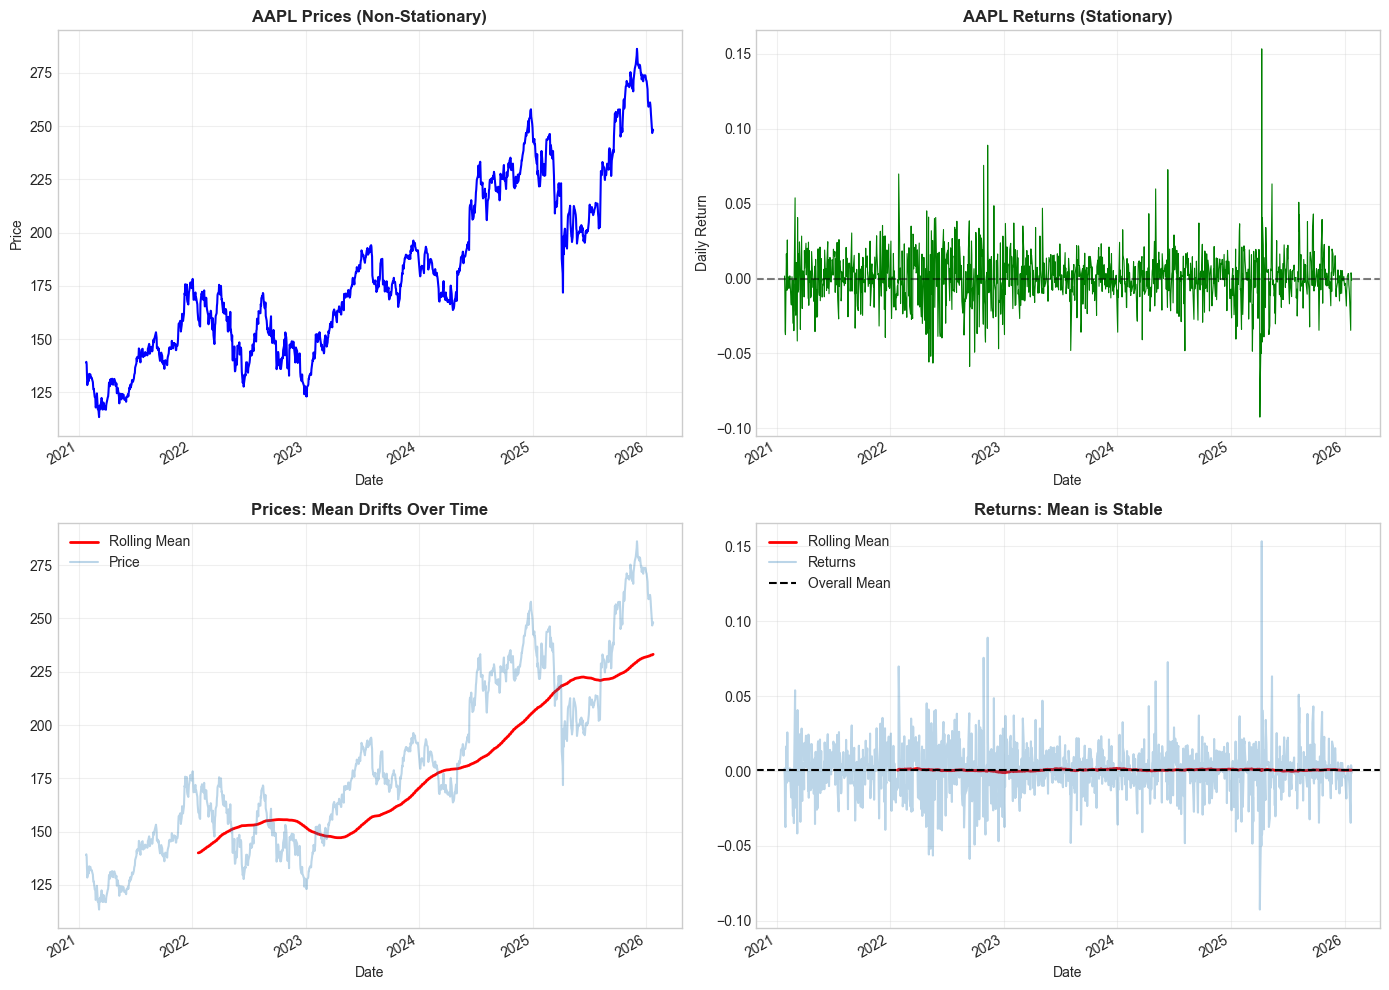

In [3]:
# Visual comparison: Prices vs Returns
print("=" * 60)
print("VISUAL: STATIONARY vs NON-STATIONARY")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prices (non-stationary)
prices['AAPL'].plot(ax=axes[0,0], color='blue', lw=1.5)
axes[0,0].set_title('AAPL Prices (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Price')
axes[0,0].grid(True, alpha=0.3)

# Returns (stationary)
returns['AAPL'].plot(ax=axes[0,1], color='green', lw=0.8)
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0,1].set_title('AAPL Returns (Stationary)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Daily Return')
axes[0,1].grid(True, alpha=0.3)

# Rolling mean comparison
window = 252
prices['AAPL'].rolling(window).mean().plot(ax=axes[1,0], label='Rolling Mean', color='red', lw=2)
prices['AAPL'].plot(ax=axes[1,0], alpha=0.3, label='Price')
axes[1,0].set_title('Prices: Mean Drifts Over Time', fontsize=12, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

returns['AAPL'].rolling(window).mean().plot(ax=axes[1,1], label='Rolling Mean', color='red', lw=2)
returns['AAPL'].plot(ax=axes[1,1], alpha=0.3, label='Returns')
axes[1,1].axhline(returns['AAPL'].mean(), color='black', linestyle='--', label='Overall Mean')
axes[1,1].set_title('Returns: Mean is Stable', fontsize=12, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Unit Root Tests

### What is a Unit Root?
A **unit root** means the series has a "memory" that doesn't decay - shocks persist forever. This is what makes prices non-stationary.

### The Two Main Tests

#### ADF Test (Augmented Dickey-Fuller)
| Property | Value |
|----------|-------|
| **H₀ (Null)** | Series has unit root (NON-stationary) |

| **H₁ (Alternative)** | Series is stationary |3. Now you can apply ARIMA

| **Decision** | Reject H₀ if p-value < 0.05 |2. If non-stationary: difference until stationary

| **Trading use** | Confirm returns are stationary |1. Test raw data

**For Forecasting:**

#### KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin)

| Property | Value |3. Otherwise: spread won't mean-revert reliably

|----------|-------|2. ADF p < 0.05 AND KPSS p > 0.05 → Good pair!

| **H₀ (Null)** | Series IS stationary |1. Test if spread is stationary

| **H₁ (Alternative)** | Series has unit root |**For Pairs Trading:**

| **Decision** | Reject H₀ if p-value < 0.05 |

| **Trading use** | Confirm stationarity |### Trading Applications



### 🎯 How to Interpret Together (Best Practice)| ≥ 0.05 | > 0.05 | ⚠️ Inconclusive (need more data) |

| < 0.05 | < 0.05 | ⚠️ Trend-stationary (detrend first) |

| ADF p-value | KPSS p-value | Conclusion || ≥ 0.05 | ≤ 0.05 | ❌ **NON-STATIONARY** (both agree) |

|-------------|--------------|------------|| < 0.05 | > 0.05 | ✅ **STATIONARY** (both agree) |

In [4]:
# Unit Root Tests
print("=" * 60)
print("UNIT ROOT TESTS")
print("=" * 60)

def stationarity_tests(series, name):
    """Run ADF and KPSS tests and report results."""
    print(f"\n{'='*50}")
    print(f"Testing: {name}")
    print(f"{'='*50}")
    
    # ADF Test
    adf_result = adfuller(series.dropna(), autolag='AIC')
    adf_stat, adf_p = adf_result[0], adf_result[1]
    
    print(f"\nADF Test (H0: Non-stationary):")
    print(f"  Test Statistic: {adf_stat:.4f}")
    print(f"  p-value:        {adf_p:.6f}")
    print(f"  Critical Values: 1%: {adf_result[4]['1%']:.3f}, 5%: {adf_result[4]['5%']:.3f}")
    print(f"  Conclusion:     {'STATIONARY ✓' if adf_p < 0.05 else 'NON-STATIONARY ✗'}")
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    kpss_stat, kpss_p = kpss_result[0], kpss_result[1]
    
    print(f"\nKPSS Test (H0: Stationary):")
    print(f"  Test Statistic: {kpss_stat:.4f}")
    print(f"  p-value:        {kpss_p:.4f}")
    print(f"  Conclusion:     {'STATIONARY ✓' if kpss_p > 0.05 else 'NON-STATIONARY ✗'}")
    
    # Combined interpretation
    if adf_p < 0.05 and kpss_p > 0.05:
        verdict = "STATIONARY (both tests agree)"
    elif adf_p >= 0.05 and kpss_p <= 0.05:
        verdict = "NON-STATIONARY (both tests agree)"
    else:
        verdict = "INCONCLUSIVE (tests disagree)"
    
    print(f"\n  VERDICT: {verdict}")
    return adf_p, kpss_p

# Test prices and returns
stationarity_tests(prices['AAPL'], 'AAPL Prices')
stationarity_tests(returns['AAPL'], 'AAPL Returns')
stationarity_tests(log_returns['AAPL'], 'AAPL Log Returns')

UNIT ROOT TESTS

Testing: AAPL Prices

ADF Test (H0: Non-stationary):
  Test Statistic: -1.1174
  p-value:        0.708067
  Critical Values: 1%: -3.436, 5%: -2.864
  Conclusion:     NON-STATIONARY ✗

KPSS Test (H0: Stationary):
  Test Statistic: 4.9893
  p-value:        0.0100
  Conclusion:     NON-STATIONARY ✗

  VERDICT: NON-STATIONARY (both tests agree)

Testing: AAPL Returns

ADF Test (H0: Non-stationary):
  Test Statistic: -34.9247
  p-value:        0.000000
  Critical Values: 1%: -3.436, 5%: -2.864
  Conclusion:     STATIONARY ✓

KPSS Test (H0: Stationary):
  Test Statistic: 0.0321
  p-value:        0.1000
  Conclusion:     STATIONARY ✓

  VERDICT: STATIONARY (both tests agree)

Testing: AAPL Log Returns

ADF Test (H0: Non-stationary):
  Test Statistic: -34.7661
  p-value:        0.000000
  Critical Values: 1%: -3.436, 5%: -2.864
  Conclusion:     STATIONARY ✓

KPSS Test (H0: Stationary):
  Test Statistic: 0.0340
  p-value:        0.1000
  Conclusion:     STATIONARY ✓

  VERDICT

(0.0, np.float64(0.1))

## 3. Transforming Non-Stationary Data

| **Portfolio** | Sum weighted returns | Not additive across assets |

### Methods to Achieve Stationarity| **Large returns** | Different | Different |

| **Small returns** | ≈ same | ≈ same |

| Transformation | Formula | When to Use | Trading Use || **Symmetry** | -50% and +100% different | Symmetric around 0 |

|---------------|---------|-------------|-------------|| **Aggregation** | Multiply for multi-period | Add for multi-period ✅ |

| **First Difference** | Yₜ - Yₜ₋₁ | Prices → Price changes | Convert prices to returns-like ||----------|---------------|-------------|

| **Log Returns** | ln(Pₜ/Pₜ₋₁) | Most common in finance | Standard return calculation || Property | Simple Returns | Log Returns |

| **Percentage Returns** | (Pₜ - Pₜ₋₁)/Pₜ₋₁ | Portfolio analysis | Easy interpretation |

| **Second Difference** | Δ²Yₜ | If first difference not enough | Rare in finance |### Why Log Returns vs Simple Returns?

| **Log Transform** | ln(Yₜ) | Stabilize variance | Sometimes before differencing |

```

### 🎯 I(d) Notation - Integration Order        print("I(1) - Use returns for analysis")

    if adf_p < 0.05:

| Notation | Meaning | Example | How to Make Stationary |    adf_p = adfuller(returns)[1]

|----------|---------|---------|------------------------|    returns = prices.pct_change().dropna()

| **I(0)** | Already stationary | Returns | No transformation needed |    # Step 2: Try first difference (returns)

| **I(1)** | One difference needed | Prices | First difference |else:

| **I(2)** | Two differences needed | Rare | Difference twice |    print("Already stationary")  # Rare for prices

if adf_p < 0.05:

### Practical Workflowadf_p = adfuller(prices)[1]

# Step 1: Test original series
```python

TRANSFORMATIONS FOR STATIONARITY

ADF Test Results for Various Transformations:
--------------------------------------------------
Transformation            ADF Stat     p-value      Stationary?
--------------------------------------------------
Original (Price)          -1.1174      0.708067     ✗ No
First Difference          -33.7041     0.000000     ✓ Yes
Log Transform             -1.1869      0.679193     ✗ No
Log Returns               -34.7661     0.000000     ✓ Yes
Second Difference         -13.6904     0.000000     ✓ Yes


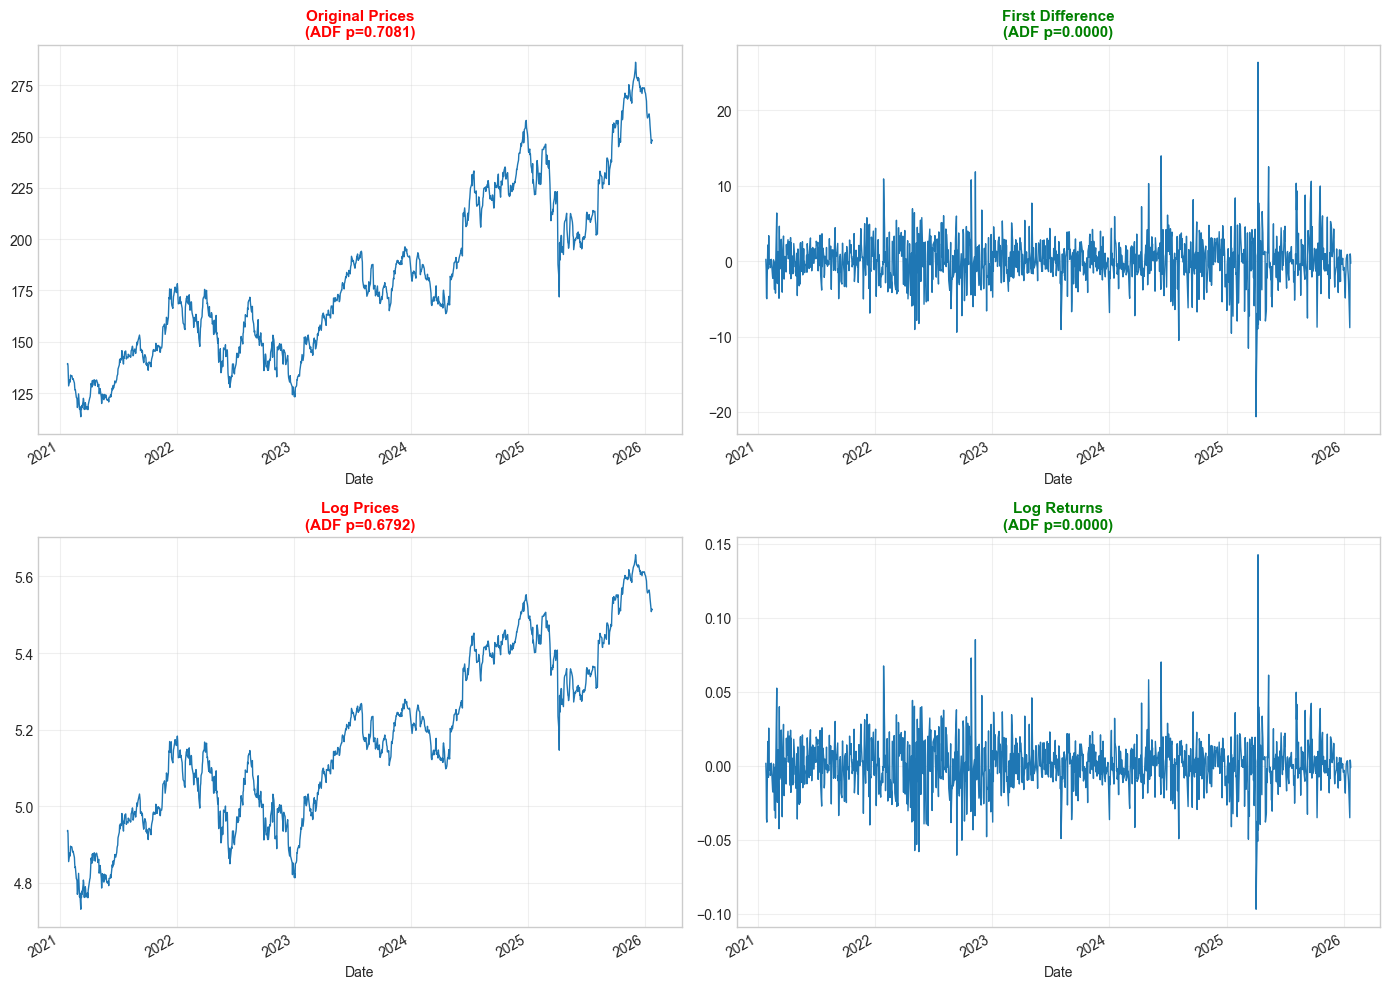

In [5]:
# Transformations to achieve stationarity
print("=" * 60)
print("TRANSFORMATIONS FOR STATIONARITY")
print("=" * 60)

aapl_price = prices['AAPL']

# Different transformations
transformations = {
    'Original (Price)': aapl_price,
    'First Difference': aapl_price.diff().dropna(),
    'Log Transform': np.log(aapl_price),
    'Log Returns': np.log(aapl_price / aapl_price.shift(1)).dropna(),
    'Second Difference': aapl_price.diff().diff().dropna()
}

print("\nADF Test Results for Various Transformations:")
print("-" * 50)
print(f"{'Transformation':<25} {'ADF Stat':<12} {'p-value':<12} {'Stationary?'}")
print("-" * 50)

for name, series in transformations.items():
    adf_stat, adf_p, _, _, crit, _ = adfuller(series.dropna(), autolag='AIC')
    stationary = '✓ Yes' if adf_p < 0.05 else '✗ No'
    print(f"{name:<25} {adf_stat:<12.4f} {adf_p:<12.6f} {stationary}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

transformations_viz = {
    'Original Prices': aapl_price,
    'First Difference': aapl_price.diff().dropna(),
    'Log Prices': np.log(aapl_price),
    'Log Returns': np.log(aapl_price / aapl_price.shift(1)).dropna()
}

for ax, (name, series) in zip(axes.flatten(), transformations_viz.items()):
    series.plot(ax=ax, lw=1)
    adf_p = adfuller(series.dropna())[1]
    color = 'green' if adf_p < 0.05 else 'red'
    ax.set_title(f"{name}\n(ADF p={adf_p:.4f})", fontsize=11, fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. I(0) vs I(1) Processes

- **I(0)**: Stationary - no differencing needed
- **I(1)**: Need one difference to become stationary
- **I(2)**: Need two differences (rare in finance)

In [6]:
# Determine integration order
print("=" * 60)
print("INTEGRATION ORDER: I(d)")
print("=" * 60)

def find_integration_order(series, max_d=3):
    """Find the integration order d such that series is I(d)."""
    current = series.dropna()
    for d in range(max_d + 1):
        adf_p = adfuller(current.dropna())[1]
        if adf_p < 0.05:
            return d
        current = current.diff().dropna()
    return max_d

print("\nIntegration Order for Various Series:")
print("-" * 40)

test_series = {
    'AAPL Price': prices['AAPL'],
    'AAPL Returns': returns['AAPL'],
    'AAPL Price': prices['AAPL'],
    'AAPL Returns': returns['AAPL'],
    'Log(AAPL)': np.log(prices['AAPL'])
}

for name, series in test_series.items():
    d = find_integration_order(series)
    print(f"{name:<20}: I({d})")

print("\n💡 Key Insight:")
print("   - Prices are I(1) → Need one difference")
print("   - Returns are I(0) → Already stationary")
print("   - Always work with returns for modeling!")

INTEGRATION ORDER: I(d)

Integration Order for Various Series:
----------------------------------------
AAPL Price          : I(1)
AAPL Returns        : I(0)
Log(AAPL)           : I(1)

💡 Key Insight:
   - Prices are I(1) → Need one difference
   - Returns are I(0) → Already stationary
   - Always work with returns for modeling!


In [7]:
# Compare all assets
print("=" * 60)
print("STATIONARITY ACROSS ASSETS")
print("=" * 60)

assets = ['AAPL', 'MSFT', 'GOOGL', 'JPM']

results = []
for asset in assets:
    price_adf = adfuller(prices[asset].dropna())[1]
    return_adf = adfuller(returns[asset].dropna())[1]
    
    results.append({
        'Asset': asset,
        'Price ADF p-value': price_adf,
        'Price Stationary': 'Yes' if price_adf < 0.05 else 'No',
        'Return ADF p-value': return_adf,
        'Return Stationary': 'Yes' if return_adf < 0.05 else 'No'
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

print("\n✅ Conclusion: Prices are NON-stationary, Returns ARE stationary")

STATIONARITY ACROSS ASSETS

Asset  Price ADF p-value Price Stationary  Return ADF p-value Return Stationary
 AAPL           0.708067               No                 0.0               Yes
 MSFT           0.720127               No                 0.0               Yes
GOOGL           0.998400               No                 0.0               Yes
  JPM           0.968773               No                 0.0               Yes

✅ Conclusion: Prices are NON-stationary, Returns ARE stationary


## 📝 Key Takeaways - Day 1

### Stationarity:
- Most time series models require stationarity
- Prices are typically I(1), returns are I(0)
- Always check before modeling!

### Unit Root Tests:
| Test | H₀ | Reject if... |
|------|----|--------------|
| ADF | Non-stationary | p < 0.05 |
| KPSS | Stationary | p < 0.05 |

### Transformations:
- First difference: Xₜ - Xₜ₋₁
- Log returns: ln(Pₜ/Pₜ₋₁)
- Both make prices stationary

### Interview Questions:
- "Why can't you use prices directly in regression?"
- "What's the difference between ADF and KPSS tests?"
- "What does I(1) mean?"

## 🔴 PROS & CONS: Stationarity Unit Root

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Stationarity Unit Root Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 09:59

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
